# Preâmbulo

Imports básicos


In [1]:
! pip install torchtext==0.8.1

# Basic imports.
import os, csv, time, random
import pandas as pd
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F

from sklearn import metrics
from sklearn.model_selection import train_test_split

from torchvision import models

from torchtext import data
from torchtext import datasets

import spacy
! python -m spacy download en
! python -m spacy download fr

from matplotlib import pyplot as plt
%matplotlib inline

SEED = 1234
torch.manual_seed(SEED)

     |████████████████████████████████| 7.0MB 7.5MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchvision 0.9.0+cu101 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.7MB 8.5MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp37-none-any.whl size=14727027 sha256=b78c5d83766f71d7db8fdd16da2b86916b45331c848fcc60815e5a915b321c2e
  Stored

In [2]:
# Setting predefined arguments.
args = {
    'epoch_num': 100,       # Number of epochs.
    'lr': 1e-3,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 6,     # Number of workers on data loader.
    'batch_size': 10,     # Mini-batch size.
    'max_length': 50,    # Maximun length of predicted sentence
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Generating Sequences


Dentre os tipos de problemas solucionáveis com modelos recorrentes, dois deles são baseados em geração de sequências: Os problemas One-to-Many,  e os Many-to-Many não sincronizados. <br>

Tipicamente os modelos de geração de sequências são baseados em arquiteturas **Encoder-Decoder**, onde a entrada é codificada para uma forma fixa, e então decodificada passo a passo em uma sequência.

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg" width="600">


## One-to-Many: Image Captioning

O problema de legendar (ou descrever) imagens, se encaixa na categoria One-to-Many, pois cada imagem é considerada uma unidade atômica, ou seja, não é modelada como uma sequência. Já a saída é uma sequência de caracteres semanticamente relacionados com a imagem. Na figura a seguir vemos uma representação superficial do problema.

<img src="https://drive.google.com/uc?export=view&id=10YhOB7pvnhXUhqu08JNJ-YcgoyPp8c3K" height="350">

Em termos de modelagem de solução, temos que a imagem deve ser mapeada para um espaço latente que provê um vetor de características de contexto (**context feature**).  Essa etapa consiste na codificação da sua entrada (**encoder**), destacando características semanticamente relevantes para a etapa de decodificação (**decoder**).

Sendo a saída uma sequência de palavras, é comum que o decoder seja composto por camadas recorrentes, que na primeira iteração recebem como entrada:
*  Hidden state inicial ($h_0$): context feature, ou seja, a saída produzida pelo encoder
*  Input inicial ($x_0$): Token especial de início de sequência (**```<sos>```** - start of sequence)

As iterações seguintes recebem como entrada os resultados produzidos na iteração anterior, ou seja:
*  Hidden state inicial ($h_t$): $h_{t-1}$
*  Input inicial ($x_t$): $y_{t-1}$

O fim das iterações é determinado pela geração do token **```<eos>```** indicando o término da sequência (end of sequence). A figura a seguir apresenta uma representação visual desse pipeline. Em azul é apresentada a entrada única do decoder (```<sos>```) e em vermelho as saídas do modelo.<br><br>

<img src="https://drive.google.com/uc?export=view&id=1j7SUTfGIHi7XIPv8YRKF1XLTTmJfvQrd" width="750"><br><br>


O código a seguir apresenta uma ilustração de pequeno porte de um modelo de Image Captioning, sem adição de transformações ou modelos de atenção. Para problemas do mundo real, aplicar o conceito de Atenção melhora significativemente a qualidade de modelos, mas a princípio vamos concentrar na arquitetura recorrente Encoder-Decoder. <br>
Para quem quiser saber mais, recomendo esse tutorial de Image Captioning: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning

Perceba no código a seguir a implementação de dois tipos de ```forward()```:
* ```forward_inference()```: A forma mais direta de decodificar a entrada em uma sequência de tokens, usando a saída do timestep anterior como entrada do timestep seguinte. Requer a implementação de um **loop explícito**, diferente do forward encapsulado que vínhamos utilizando.
* ```forward()```: Em tempo de treino, é possível realizar o forward encapsulado, alimentando a sequência target como entrada do modelo recorrente. Nesse caso o comprimento das sequências é conhecido, e o loop encapsulado pode ser interrompido ao final da sequência target. **Na prática recomenda-se fazer parte do treinamento com os targets e outra parte sem**. A figura a seguir apresenta a diferença sutil que permite o encapsulamento do forward de batches. Novamente em azul são apresentadas as entradas fornecidas ao modelo, e em vermelho as saídas. <br><br>

<img src="https://drive.google.com/uc?export=view&id=1XBnnnbAWx2y63JiZ9G8zBtxxll0YpV_F" width="750"> <br><br>

Vale explicitar que **cada iteração no decoder é composta pelas camadas de embedding, RNN e Linear**, como apresentado na figura a seguir.


<img src="https://drive.google.com/uc?export=view&id=1eFDgd6gn_l-lcKcQIuQA7ooI_ZkvWYrp" width="500">

In [3]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, output_size, max_length, dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        
        self.embed_size  = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.dropout_p = dropout_p
        self.max_length = max_length

        # Word embedding
        self.embedding = nn.Embedding(self.output_size, self.embed_size)
        
        # Recurrent feature
        self.gru = nn.GRU(self.embed_size, self.hidden_size)
        
        # Classify next word
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, hidden, target=None, lengths=None):

        if target is None:
          return self.forward_inference(hidden)
      
        embedded = self.embedding(target)

        packed_inputs = nn.utils.rnn.pack_padded_sequence(embedded, lengths)        
        packed_outputs, hidden = self.gru(packed_inputs, hidden)
        output_rnn, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        output = self.softmax(self.out(output_rnn))
        
        return output

      
    def forward_inference(self, hidden):
      
        # Start inference with <sos> token
        input = torch.tensor(TEXT.vocab.stoi["<sos>"]).to(args['device'])
        
        outputs = []
        # Iterate to a maximum length
        for i in range(self.max_length):
          
          # Forward single sample
          embedded = self.embedding(input).view(1,1,-1)
          output_rnn, hidden = self.gru(embedded, hidden)
          output = self.softmax(self.out(output_rnn[0]))
          
          outputs.append(output.detach())
          
          # Current output feeds future input
          topv, topi = output.topk(1)
          input = topi.squeeze().detach()  

          # Finish inference when <eos> generated
          if input == TEXT.vocab.stoi["<eos>"]:
            break
            
        # Return sequence of tokens produced 
        # Either interrupted by producing <eos>
        # Or interrupted by max_length
        return torch.stack(outputs)
          
        
####### Build encoder ###########
# encoder = models.resnet18(pretrained=True)
encoder = models.resnet18(pretrained=True)
num_features = encoder.fc.in_features

# Remove linear layers
modules = list(encoder.children())[:-2]
encoder = nn.Sequential(*modules)
#################################


####### Build decoder ###########
vocab_size   = 20_000
embed_size   = 100
hidden_size  = num_features
max_length   = args['max_length'] 

decoder = DecoderRNN(embed_size, hidden_size, vocab_size, max_length).to(args['device'])
#################################

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [4]:
print(encoder)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [5]:
print(decoder)

DecoderRNN(
  (embedding): Embedding(20000, 100)
  (gru): GRU(100, 512)
  (out): Linear(in_features=512, out_features=20000, bias=True)
  (softmax): LogSoftmax(dim=-1)
)


## Sequence-to-sequence models (Seq2Seq)

Attention tutorial tensorflow: https://www.tensorflow.org/tutorials/text/nmt_with_attention

Modelos Sequence-to-Sequence (Seq2Seq) partem do mesmo princípio do Image Captioning, porém a entrada também é sequencial, de modo que a codificação também é realizada por um modelo recorrente. 

A atividade de hoje é no contexto de Neural Machine Translation (NMT), cujo pipeline é representado de forma simplificada a seguir. Note que o idioma source (francês) necessita apenas do token de finalização de sentença, enquanto o idioma target precisa de ambos os inicializadores e os finalizadores (```<sos>```, ```<eos>```), visto que a entrada da rede precisa do token de inicialização, mas a saída, através da qual será calculada a loss, é produzida apenas com a finalização.

![](https://pytorch.org/tutorials/_images/seq2seq.png)

Imagem retirada do tutorial de NMT do Pytorch: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

Encontre modelos de linguagem pré-treinados e arquiteturas implementadas em: http://opennmt.net/


In [6]:
# Baixando Dataset
!wget https://www.dropbox.com/s/gq36ksk347d36ln/translation_data.zip
!unzip translation_data.zip

--2021-03-16 22:07:51--  https://www.dropbox.com/s/gq36ksk347d36ln/translation_data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/gq36ksk347d36ln/translation_data.zip [following]
--2021-03-16 22:07:52--  https://www.dropbox.com/s/raw/gq36ksk347d36ln/translation_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9a1ee758046504f3016ff05577.dl.dropboxusercontent.com/cd/0/inline/BK3v8EdfBqOoYRWPKFLbwwM5gGY9NAhfKLZOe3ckkKsj4DklzfambafkVFJtArioflw2LJC2KFh4iPBOZcC1dB1gB1tUwC3-q0QrcGrCb_oOvU_6p06Brz2I3hUkMB3Fw4IYnFJfrClN_OQMyamb9yNm/file# [following]
--2021-03-16 22:07:52--  https://uc9a1ee758046504f3016ff05577.dl.dropboxusercontent.com/cd/0/inline/BK3v8EdfBqOoYRWPKFLbwwM5gGY9NAhfKLZOe3ckkKsj4DklzfambafkVFJtAriofl

In [7]:
# Criando CSV de treino e teste para carregar com o TabularDataset

translation_path = 'data/eng-fra.txt'

samples = open(translation_path).read().split('\n')
  
# Write txt to csv
lines = (line.split("\t") for line in samples)
with open('translation_data.csv', 'w') as out_file:
    writer = csv.writer(out_file)
    writer.writerow(('English', 'French'))
    writer.writerows(lines)
    
df = pd.read_csv('translation_data.csv')

# Reducing data (throwing out samples)
train, _ = train_test_split(df, test_size=0.6)

# Split train and test set 
train, test = train_test_split(train, test_size=0.02)

train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

df = pd.read_csv('test.csv')
df.tail()

,English,French
1082,I've been waiting here for him since this morn...,Je l'ai attendu ici depuis ce matin.
1083,She was ashamed of herself for her carelessness.,Elle avait honte de son inattention.
1084,Is this translation correct?,Cette traduction est-elle correcte ?
1085,They cheat.,Elles trichent.
1086,You and I are going together.,Toi et moi y allons ensemble.


In [8]:
# Preparação do dataset:
# Tokenização e inclusão dos tokens especiais (<eos>, <sos>, <pad>, <unk>)
TEXT_FR = data.Field(tokenize = 'spacy', 
                     tokenizer_language='fr',
                     lower=True, 
                     include_lengths=True, 
                     eos_token = "<eos>")

TEXT_EN = data.Field(tokenize = 'spacy', 
                     tokenizer_language='en', 
                     lower=True,
                     include_lengths=True, 
                     init_token = "<sos>", 
                     eos_token = "<eos>")

fields = [('text_en', TEXT_EN), ('text_fr', TEXT_FR)]
train_data, test_data = data.TabularDataset.splits(
                                  path = '.',
                                  train = 'train.csv',
                                  test = 'test.csv',
                                  format = 'csv',
                                  fields = fields,
                                  skip_header = True)

for sample in train_data:
  print(sample.text_fr)
  print(sample.text_en)
  break
  
print(len(train_data), len(test_data))

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

['je', 'prendrai', 'soin', 'du', 'chat', '.']
['i', "'ll", 'take', 'care', 'of', 'the', 'cat', '.']
53250 1087


In [9]:
# Criando vocabulário
MAX_VOCAB_SIZE = 25_000

TEXT_EN.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE)

TEXT_FR.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE)


# Instanciando bucket iterator
# Note que a ordenação é definida pelo 
# comprimento do par ** (en, fr) **
# Precisaremos empacotar ambas as sequências 
# para realizar o forward encapsulado.
train_iterator = data.BucketIterator(
    train_data, 
    batch_size = args['batch_size'],
    sort_key = lambda x:(len(x.text_fr), len(x.text_en)),
    sort_within_batch = True,
    device = args['device'])


test_iterator = data.BucketIterator(
    test_data, 
    batch_size = 1,
    sort_within_batch = False,
    device = args['device'])

for k, batch in enumerate(train_iterator):
  text_fr, lengths_fr = batch.text_fr
  text_en, lengths_en = batch.text_en
  
  print(text_fr)
  print(text_en)
  print(lengths_fr)
  print(lengths_en)
  break


tensor([[    4,    42,    26,    32,    18,    31,    20,    14,    14,    20],
        [   35, 14516,    78,    67,  4002,  6578,    24,   151,   309,    24],
        [  511,  6985,   106,    19,  4184,    95,   637,     9,     7,   280],
        [   11, 12360,   642,    85,    22, 10189,    28,     8,    22,    11],
        [    8,    95,  5897,    36,  3832,    57,   119,   274,   437,     8],
        [    8,    79,   103,    32,  2547,    42,    34,    22,    13,   510],
        [   27,  7661,    89,  3460,     5,  9452,  2324,   126,    51,   109],
        [14654,    13,    26,    27,    16,    68,    13,    45,    11,   108],
        [   74,    18,    48,    18,  6875,    42,    64,   290,    25,    28],
        [   93,   974,   596,  6657,  6592, 11659,  1095,    38,   134,   215],
        [    3,     3,     3,     3,     3,     3,     3,     6,     3,     3],
        [    2,     2,     2,     2,     2,     2,     2,     2,     2,     2]],
       device='cuda:0')
tensor([[   2, 

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


# Atividade Prática

Implemente a arquitetura apresentada na figura abaixo através da realização dos seguintes passos:

### EncoderRNN

Implemente a classe **EncoderRNN** composta de um passo de representação de palavras e um passo de caracterização de sequência, ou seja, implemente as seguintes camadas:
*  Embedding: como não usaremos vetores pré-treinados, a dimensão de saída dessa camada é um hiperparâmetro livre. Sugestão de tamanho: ```100```. Sua entrada é definida pelo tamanho do dicionário do idioma source (nesse caso o francês).
*  Dropout: ```0.1``` <br><br>
*  GRU: Defina ```hidden_size = 128``` para o encoder

### DecoderRNN

Implemente a classe **DecoderRNN**. Novamente é necessário uma camada de representação de palavras, seguida de uma camada de caracterização de sequências. Além disso, o decoder também deve possuir uma camada Linear de classificação, que transformará a representação de cada timestep (saída da RNN) em uma predição da próxima palavra.

* Embedding: A entrada definida pelo vocabulário do idioma target (inglês), saída é um hiperparâmetro livre (sugestão: ```100```).
* Dropout: ```0.1``` <br><br>
* GRU: Seus hiperparâmetros são inferíveis a partir das outras informações. **Lembre-se que a inicialização do hidden state é dada pelo último hidden state do encoder** (veja na função train). <br><br>
* Linear: Parâmetros inferíveis pelas outras informações. Quantas classes tem a predição de palavras em inglês?
* LogSoftmax: ativação da classificação.

No decoder, **implemente ambos os forward** para treinamento (encapsulado em batches) e para inferência (loop explícito sem targets).

<img src="https://drive.google.com/uc?export=view&id=1j8aLVymyvhGtM0lpfON0aDyPvUf4700U" width="850">

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1, num_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.dropout_p   = dropout_p
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, inputs, lengths):
      
        batch_size = inputs.size(1)
        hidden = self.initHidden(batch_size)
        
        embedded = self.dropout(self.embedding(inputs))
      
        packed_inputs = nn.utils.rnn.pack_padded_sequence(embedded, lengths)
        packed_outputs, hidden = self.gru(packed_inputs, hidden)
        outputs, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        return outputs, hidden[-1:]

    def initHidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(args['device'])
      
      
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length, dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, hidden, target=None, lengths=None):

        if target is None:
          return self.forward_inference(hidden)
      
        embedded = self.dropout(self.embedding(target))

        packed_inputs = nn.utils.rnn.pack_padded_sequence(embedded, lengths)        
        packed_outputs, hidden = self.gru(packed_inputs, hidden)
        output_rnn, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        output = self.softmax(self.out(output_rnn))
        
        return output

      
    def forward_inference(self, hidden):
        input = torch.tensor(TEXT_EN.vocab.stoi["<sos>"]).to(args['device'])
        
        outputs = []
        for i in range(self.max_length):
          
          embedded = self.embedding(input).view(1,1,-1)
          output_rnn, hidden = self.gru(embedded, hidden)
          output = self.softmax(self.out(output_rnn[0]))
          
          topv, topi = output.topk(1)
          input = topi.squeeze().detach()  # detach from history as input

          outputs.append(output)
          if input == TEXT_EN.vocab.stoi["<eos>"]:
            break
            
        return torch.stack(outputs)
      

vocab_size_en = len(TEXT_EN.vocab)
hidden_size   = 128

vocab_size_fr = len(TEXT_FR.vocab)
max_length    = args['max_length']

encoder = EncoderRNN(vocab_size_fr, hidden_size).to(args['device'])
decoder = DecoderRNN(hidden_size, vocab_size_en, max_length).to(args['device'])

print(encoder)
print(decoder)

EncoderRNN(
  (embedding): Embedding(15661, 128)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(128, 128)
)
DecoderRNN(
  (embedding): Embedding(9622, 128)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(128, 128)
  (out): Linear(in_features=128, out_features=9622, bias=True)
  (softmax): LogSoftmax(dim=-1)
)


In [11]:
# Setting optimizer.
encoder_optimizer = optim.Adam(encoder.parameters(),
                       lr=args['lr'],
                       weight_decay=args['weight_decay'],
                       betas=(args['momentum'], 0.999))

decoder_optimizer = optim.Adam(decoder.parameters(),
                       lr=args['lr'],
                       weight_decay=args['weight_decay'],
                       betas=(args['momentum'], 0.999))

# Setting loss.
criterion = nn.NLLLoss().to(args['device'])


In [12]:
grad_norm, total_norm = [], [], 
grad_norm_dec, total_norm_dec = [], []

def save_grad_flow(named_parameters, dec=False):

    param_norms = []
    
    norm = 0.
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            param_norms.append(p.grad.data.norm(2))
            
            norm += param_norms[-1].item() ** 2
    norm = norm ** (1. / 2)
    
    if dec:
      total_norm_dec.append(norm)
      grad_norm_dec.append(param_norms)
    else:
      total_norm.append(norm)
      grad_norm.append(param_norms)
    


def forward(loader, criterion, epoch, mode):

    tic = time.time()

    # Lists for losses and metrics.
    epoch_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(loader):

        # Obtaining images, labels and paths for batch.
        text, text_lengths = batch_data.text_fr
        labs, labs_lengths = batch_data.text_en
        
        # Ignorando batches não ordenados no inglês
        if sorted(labs_lengths, reverse=True) != list(labs_lengths.data):
          continue

        # Forwarding.
        enc, enc_hidden = encoder(text, text_lengths.cpu())
        if mode == 'train':
          outs = decoder(enc_hidden, labs[:-1], labs_lengths.cpu()-1)
          minlen = len(outs)
        else:
          outs = decoder(enc_hidden)  
          minlen = min(len(labs)-1, len(outs))

        # Computing loss.
        loss = 0.
        for k in range(minlen):
          loss += criterion(outs[k], labs[k+1])
        loss = loss.mean()
        

        if mode == 'train':
          # Clears the gradients of optimizer.
          encoder_optimizer.zero_grad()
          decoder_optimizer.zero_grad()

          # Computing backpropagation.
          loss.backward()

          # Saving gradient norm
          save_grad_flow(encoder.named_parameters())
          save_grad_flow(decoder.named_parameters(), dec=True)
          
          # Weight update
          encoder_optimizer.step()
          decoder_optimizer.step()
        
        else:
          if i < 2:
            print('Input:',  [TEXT_FR.vocab.itos[t] for t in text])
            print('Label:',  [TEXT_EN.vocab.itos[t] for t in labs[1:]])
            print('Output:', [TEXT_EN.vocab.itos[np.argmax(t.cpu().data)] for t in outs], '\n')

        # Updating lists.
        epoch_loss.append(loss.data.item())
    
    toc = time.time()
    
    epoch_loss = np.asarray(epoch_loss)
    
    # Printing training epoch loss and metrics.
    print('--------------------------------------------------------------------')
    print('[epoch %d], [%s loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, mode, epoch_loss.mean(), epoch_loss.std(), (toc - tic)))
    print('--------------------------------------------------------------------')


# Iterating over epochs.
for epoch in range(1,args['epoch_num'] + 1):

    # Training function.
    forward(train_iterator, criterion, epoch, 'train')

    # Computing test loss and metrics.
    forward(test_iterator, criterion, epoch, 'test')



/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


--------------------------------------------------------------------
[epoch 1], [train loss 30.7816 +/- 13.2300], [training time 37.76]
--------------------------------------------------------------------
Input: ['ne', 'commence', 'même', 'pas', 'à', 'me', '<unk>', '!', '<eos>']
Label: ['do', "n't", 'even', 'get', 'me', 'started', '.', '<eos>']
Output: ['do', "n't", 'let', 'me', 'go', '.', '<eos>'] 

Input: ['promets', '-', 'moi', 'de', 'ne', 'jamais', 'refaire', 'ça', '!', '<eos>']
Label: ['promise', 'me', 'you', "'ll", 'never', 'do', 'that', 'again', '.', '<eos>']
Output: ['do', "n't", 'be', 'so', 'much', '.', '<eos>'] 

--------------------------------------------------------------------
[epoch 1], [test loss 45.0652 +/- 20.1876], [training time 6.07]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 2], [train loss 23.3794 +/- 9.6980], [training time 38.32]
-------------------------------

# Olhando para o Gradiente

## Gradient Clipping

O clip do gradient nada mais é do que uma limitação sobre a norma L2 do gradiente da rede. Define-se uma norma limite na função ```clip_grad_norm_``` do pytorch, que por sua vez já modifica os gradientes caso sua norma total extrapole esse limite. 

Documentação Pytorch: https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html

É importante chamar a função de clipping exatamente após o cálculo dos gradientes, e antes do passo de otimização, como apresentado a seguir.

```python
# Computing backpropagation.
loss.backward()

# Clipping Gradient
torch.nn.utils.clip_grad_norm_(net.parameters(), args['clip_norm'])

# Weight update
optimizer.step()
```



## Com a RNN simples

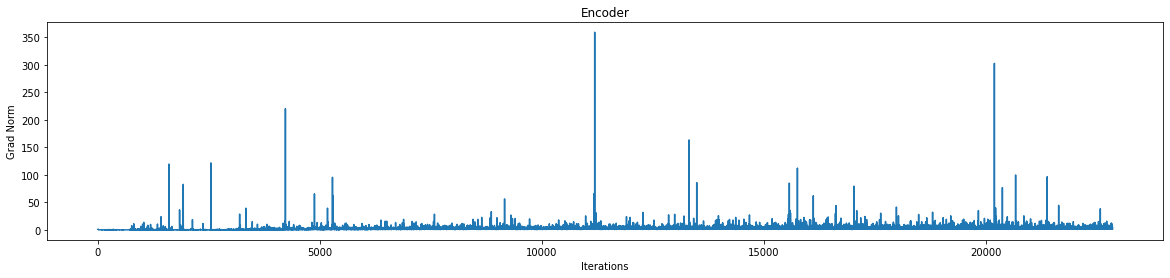

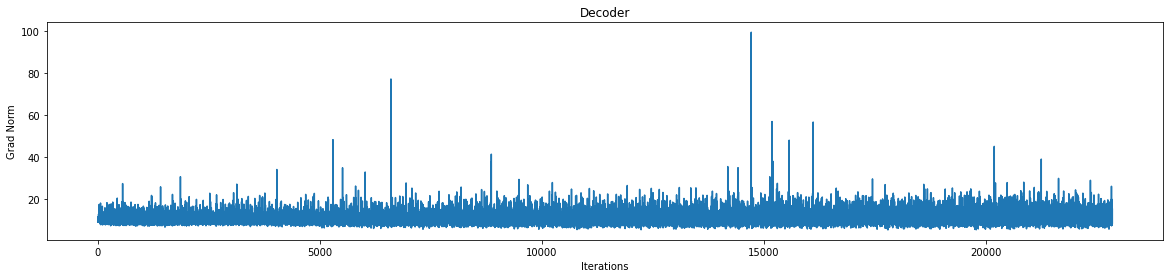

In [ ]:
plt.figure(figsize=(20,4))
plt.ylabel('Grad Norm')
plt.xlabel('Iterations')
plt.title('Encoder')
plt.plot(total_norm)

plt.figure(figsize=(20,4))
plt.ylabel('Grad Norm')
plt.xlabel('Iterations')
plt.title('Decoder')
plt.plot(total_norm_dec)

### Encoder por matriz de pesos

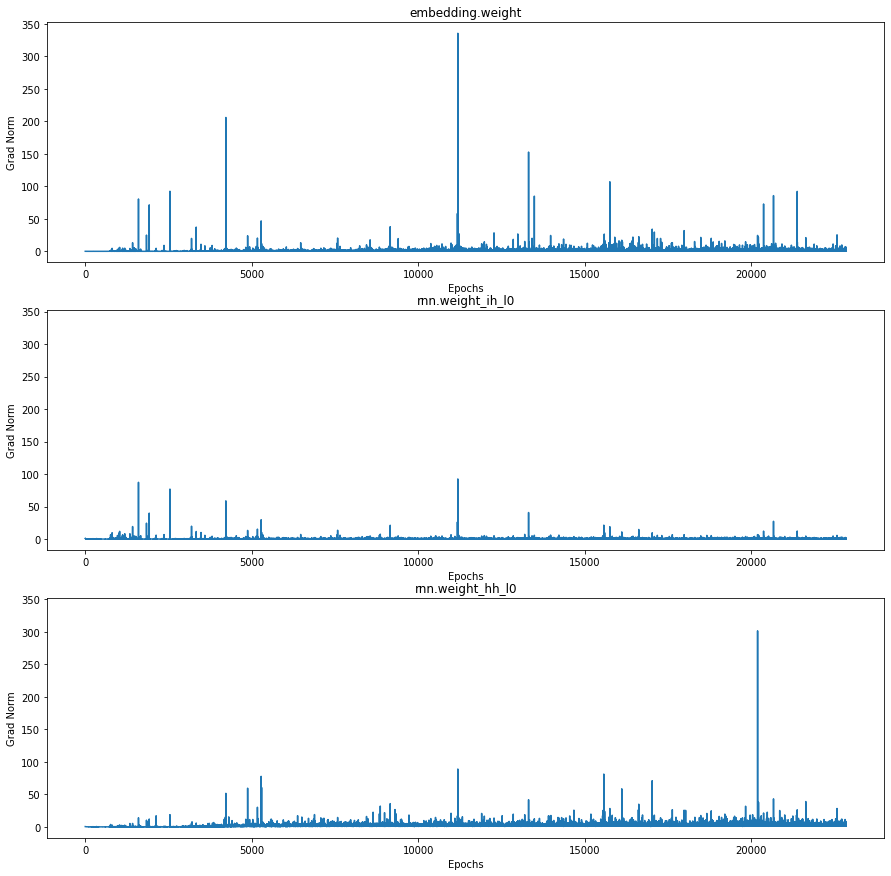

In [ ]:
# Plot gradient norm per weight
layers = []
for n, p in encoder.named_parameters():
  layers.append(n)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 15), sharey=True)
grad_norm_ = np.array(grad_norm)
for i in range(len(grad_norm[0])):
  axs[i].plot(grad_norm_[:,i])
  axs[i].set_ylabel('Grad Norm')
  axs[i].set_xlabel('Epochs')
  axs[i].set_title(layers[i])
  
plt.show()

### Decoder por matriz de pesos

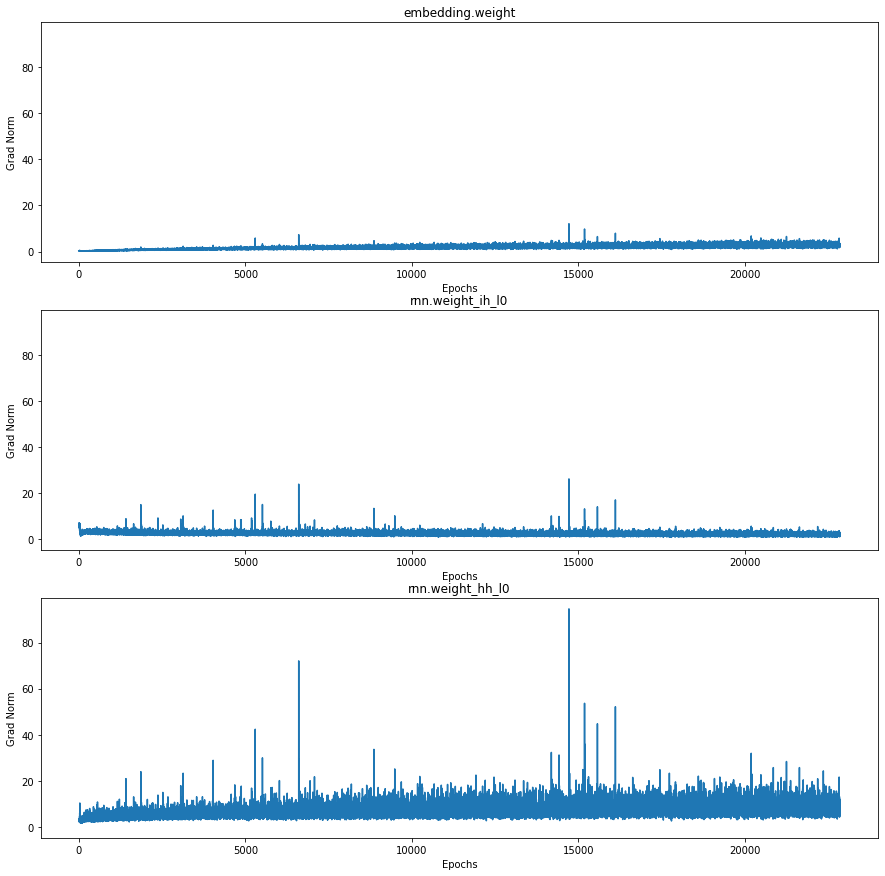

In [ ]:
# Plot gradient norm per weight
layers = []
for n, p in decoder.named_parameters():
  layers.append(n)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 15), sharey=True)
grad_norm_ = np.array(grad_norm_dec)
for i in range(len(grad_norm[0])):
  axs[i].plot(grad_norm_[:,i])
  axs[i].set_ylabel('Grad Norm')
  axs[i].set_xlabel('Epochs')
  axs[i].set_title(layers[i])
  
plt.show()

## Com a GRU

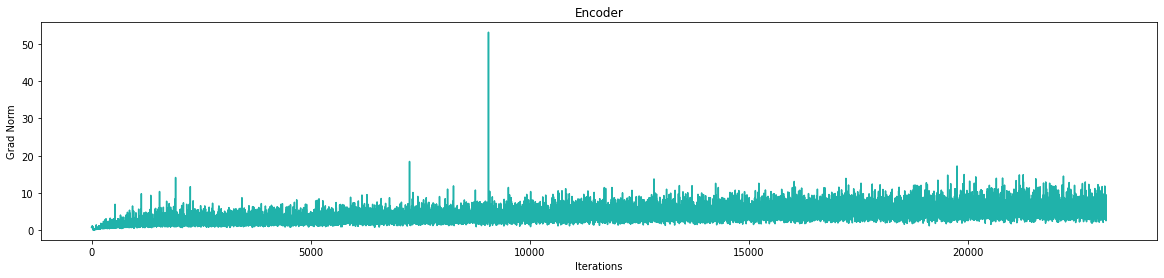

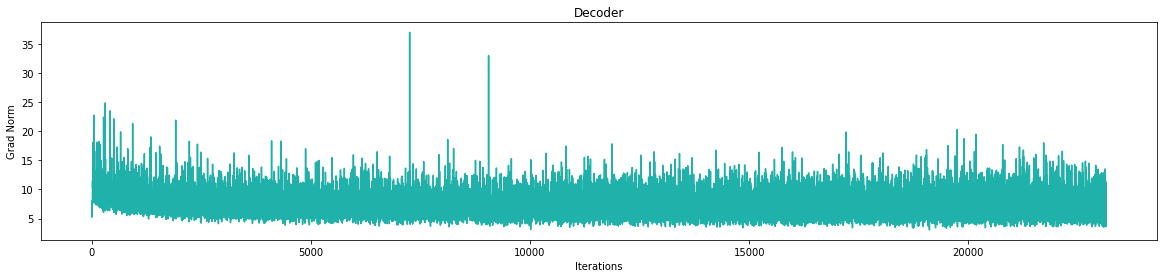

In [ ]:
# Plot total norm and loss convergence
plt.figure(figsize=(20,4))
plt.ylabel('Grad Norm')
plt.xlabel('Iterations')
plt.title('Encoder')
plt.plot(total_norm, color='lightseagreen')

plt.figure(figsize=(20,4))
plt.ylabel('Grad Norm')
plt.xlabel('Iterations')
plt.title('Decoder')
plt.plot(total_norm_dec, color='lightseagreen')

### Encoder por matriz de pesos

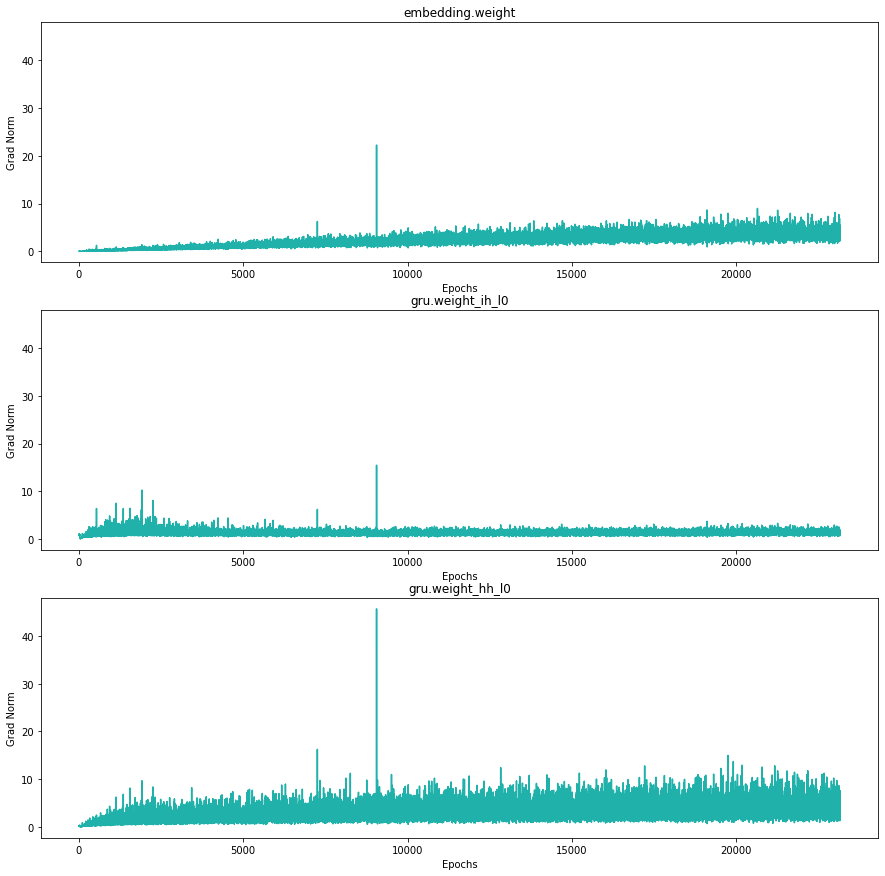

In [ ]:
# Plot gradient norm per weight
layers = []
for n, p in encoder.named_parameters():
  layers.append(n)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 15), sharey=True)
grad_norm_ = np.array(grad_norm)
for i in range(len(grad_norm[0])):
  axs[i].plot(grad_norm_[:,i], color='lightseagreen')
  axs[i].set_ylabel('Grad Norm')
  axs[i].set_xlabel('Epochs')
  axs[i].set_title(layers[i])
  
plt.show()

### Decoder por matriz de pesos

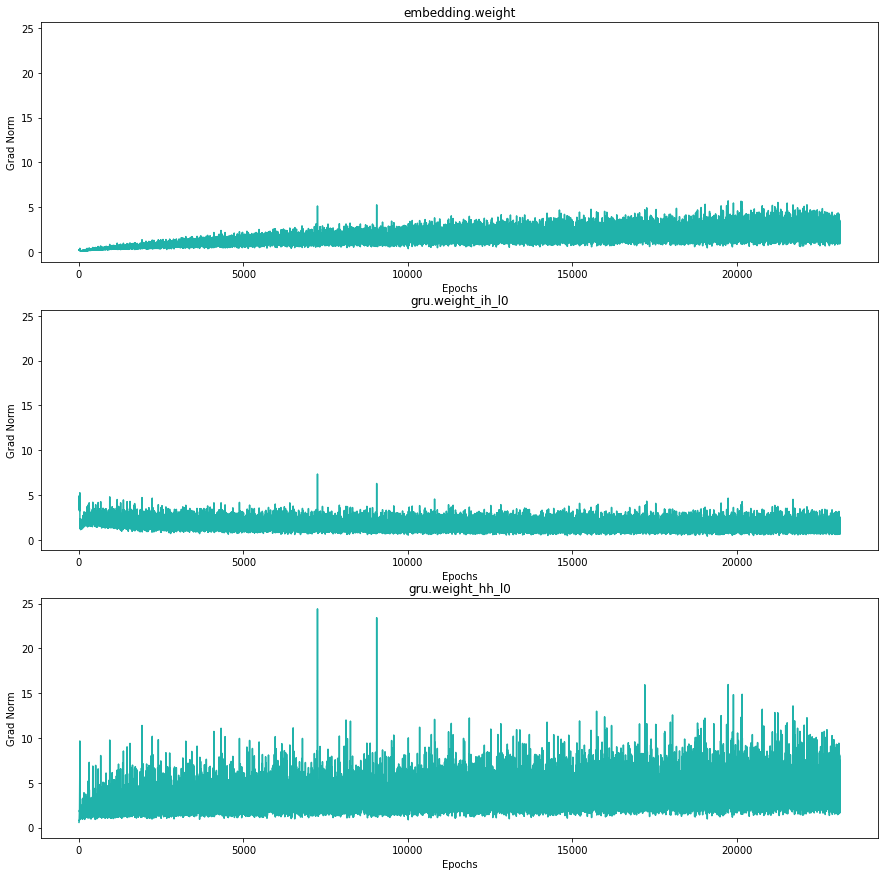

In [ ]:
# Plot gradient norm per weight
layers = []
for n, p in decoder.named_parameters():
  layers.append(n)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 15), sharey=True)
grad_norm_ = np.array(grad_norm_dec)
for i in range(len(grad_norm[0])):
  axs[i].plot(grad_norm_[:,i], color='lightseagreen')
  axs[i].set_ylabel('Grad Norm')
  axs[i].set_xlabel('Epochs')
  axs[i].set_title(layers[i])
  
plt.show()